In [19]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import timedelta

In [20]:
df = pd.read_excel('/content/patan_final.xlsx')

In [21]:
df.head()

,Date,Arrival,Price
0,2010-01-01,84.8,2755.0
1,2010-01-02,75.8,2750.0
2,2010-01-03,80.3,2752.5
3,2010-01-04,87.4,2750.0
4,2010-01-05,122.1,2770.0


In [22]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

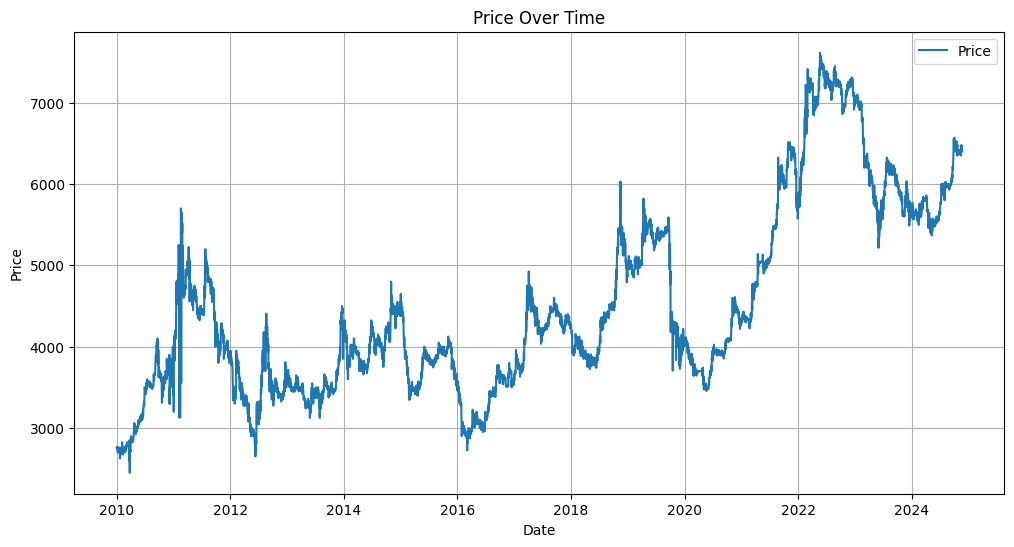

In [23]:
# Visualizing the Price data over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], label='Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Feature engineering: We will create lag features for the Random Forest model
def create_lag_features(df, lag=1):
    df_lagged = df.copy()
    for i in range(1, lag + 1):
        df_lagged[f'Lag_{i}'] = df_lagged['Price'].shift(i)
    df_lagged.dropna(inplace=True)  # Drop rows with NaN values created by shifts
    return df_lagged

In [25]:
# Create lag features (for example, 5 lags)
lag = 5
df_lagged = create_lag_features(df, lag)

In [26]:
# Split the data into training and testing sets (80% train, 50% test)
train_size = int(len(df_lagged) * 0.8)
train_data = df_lagged[:train_size]
test_data = df_lagged[train_size:]

In [27]:
# Split into features (X) and target (y)
X_train = train_data.drop(['Date', 'Price'], axis=1)
y_train = train_data['Price']
X_test = test_data.drop(['Date', 'Price'], axis=1)
y_test = test_data['Price']

In [28]:
X_train

,Arrival,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
5,80.300000,2770.000000,2750.0,2752.5,2750.0,2755.0
6,74.300000,2740.000000,2770.0,2750.0,2752.5,2750.0
7,110.100000,2750.000000,2740.0,2770.0,2750.0,2752.5
8,122.000000,2700.000000,2750.0,2740.0,2770.0,2750.0
9,99.366667,2750.000000,2700.0,2750.0,2740.0,2770.0
...,...,...,...,...,...,...
4346,210.080000,6440.000000,6455.0,6345.0,6354.0,6370.0
4347,173.180000,6410.000000,6440.0,6455.0,6345.0,6354.0
4348,224.480000,6385.000000,6410.0,6440.0,6455.0,6345.0
4349,207.023333,6450.000000,6385.0,6410.0,6440.0,6455.0


In [29]:
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [30]:
# Make predictions
train_predictions = rf_model.predict(X_train)
test_predictions = rf_model.predict(X_test)

In [31]:
# Store the predictions with dates
train_predictions_df = pd.DataFrame({'Date': train_data['Date'], 'Predicted_Price': train_predictions})
train_predictions_df.set_index('Date', inplace=True)
test_predictions_df = pd.DataFrame({'Date': test_data['Date'], 'Predicted_Price': test_predictions})
test_predictions_df.set_index('Date', inplace=True)

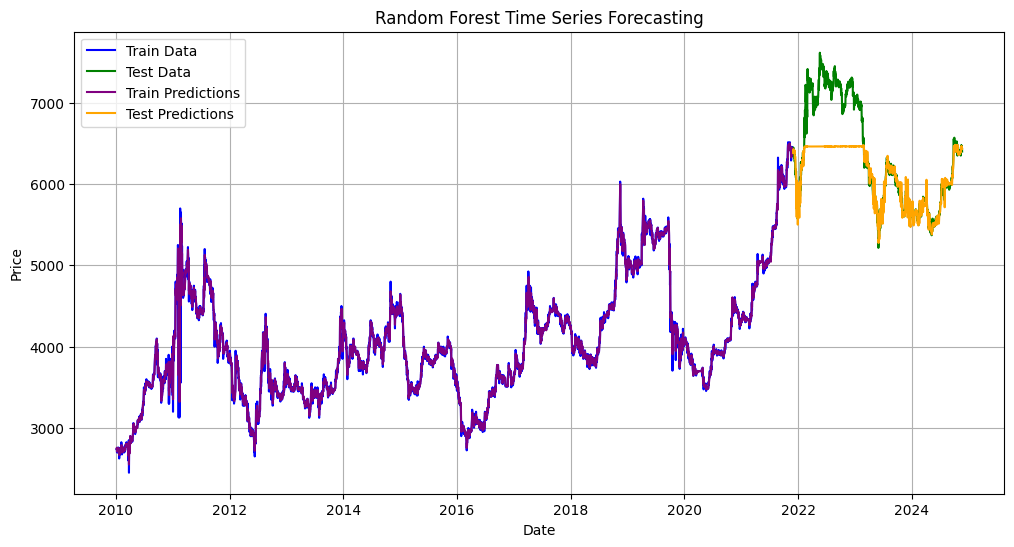

In [32]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Price'], label='Train Data', color='blue')
plt.plot(test_data['Date'], test_data['Price'], label='Test Data', color='green')
plt.plot(train_predictions_df.index, train_predictions_df['Predicted_Price'], label='Train Predictions', color='purple')
plt.plot(test_predictions_df.index, test_predictions_df['Predicted_Price'], label='Test Predictions', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Random Forest Time Series Forecasting')
plt.grid(True)
plt.show()

In [33]:
# Evaluate the model using RMSE
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)

# Calculate the range of the target variable
y_range = np.max(y_test) - np.min(y_test)

# Calculate the RMSE as a percentage of the range
rmse_percentage = (rmse / y_range) * 100

print(f'Root Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Root Mean Squared Error (RMSE) as a percentage of the range: {rmse_percentage:.2f}%')

Root Mean Squared Error (MSE): 178919.97
Root Mean Squared Error (RMSE): 422.99
Root Mean Squared Error (RMSE) as a percentage of the range: 17.62%


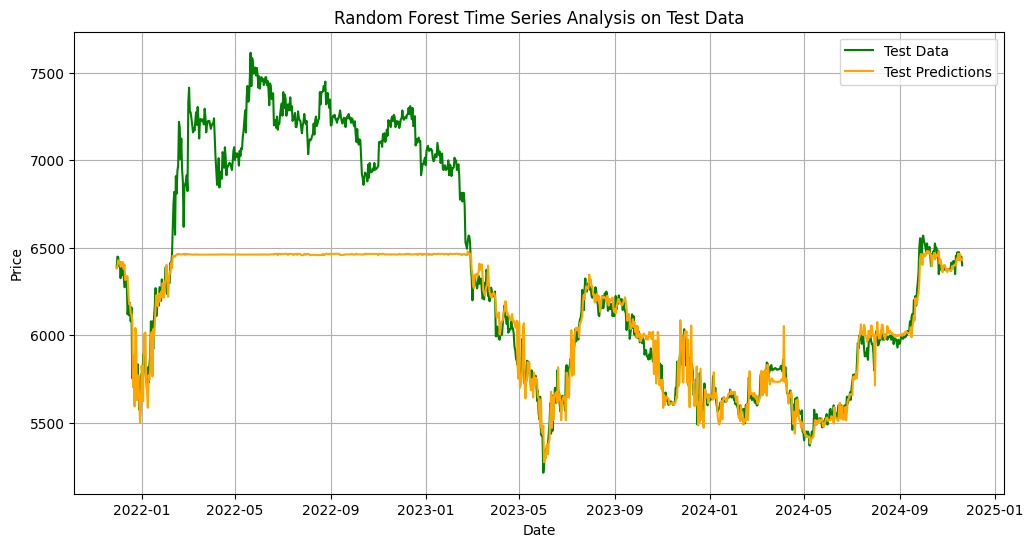

In [34]:
# Plot Test Data vs Predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], test_data['Price'], label='Test Data', color='green')
plt.plot(test_predictions_df.index, test_predictions_df['Predicted_Price'], label='Test Predictions', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Random Forest Time Series Analysis on Test Data')
plt.grid(True)
plt.show()

In [35]:
# Make future forecasts (for example, next 100 steps)
forecast_steps = 100

# Create a future DataFrame with the last known values (lags)
future_dates = pd.date_range(df['Date'].max() + timedelta(days=1), periods=forecast_steps, freq='D')

# Use the last 'lag' days from the training data to make future predictions
last_lags = train_data.iloc[-lag:][['Price']].values.flatten()  # Use the last 'lag' values from the training data

# Make predictions for the future
future_predictions = []
for i in range(forecast_steps):
    # Create a DataFrame for the future lags with all the necessary features
    future_data = pd.DataFrame(
        [[0, future_dates[i].year, future_dates[i].month, future_dates[i].day,
          future_dates[i].dayofweek, future_dates[i].weekofyear,
          future_dates[i].quarter] + list(last_lags[-lag:])],  # Add the lag values
        columns=['Arrival', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Quarter',
                 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']
    )

    # Include 'Arrival' when making predictions
    future_pred = rf_model.predict(future_data[['Arrival', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']])  # Predict the future price using all necessary features
    future_predictions.append(future_pred[0])  # Append the predicted price
    last_lags = np.append(last_lags, future_pred)  # Add the prediction to the lags for the next step

# Store the forecasted values
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_Price': future_predictions})
forecast_df.set_index('Date', inplace=True)


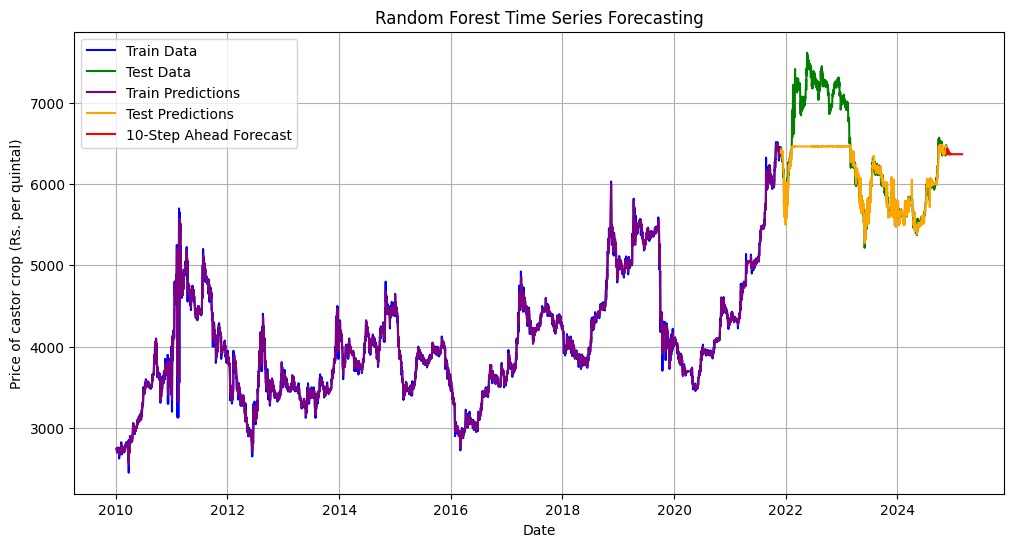

In [38]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot the training data
plt.plot(train_data['Date'], train_data['Price'], label='Train Data', color='blue')

# Plot the test data
plt.plot(test_data['Date'], test_data['Price'], label='Test Data', color='green')

# Plot the train predictions
plt.plot(train_predictions_df.index, train_predictions_df['Predicted_Price'], label='Train Predictions', color='purple')

# Plot the test predictions
plt.plot(test_predictions_df.index, test_predictions_df['Predicted_Price'], label='Test Predictions', color='orange')

# Plot the 10-step ahead forecast
plt.plot(forecast_df.index, forecast_df['Forecasted_Price'], label='10-Step Ahead Forecast', color='red')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Price of castor crop (Rs. per quintal)')
plt.legend()
plt.title('Random Forest Time Series Forecasting')
plt.grid(True)

# Show the plot
plt.show()

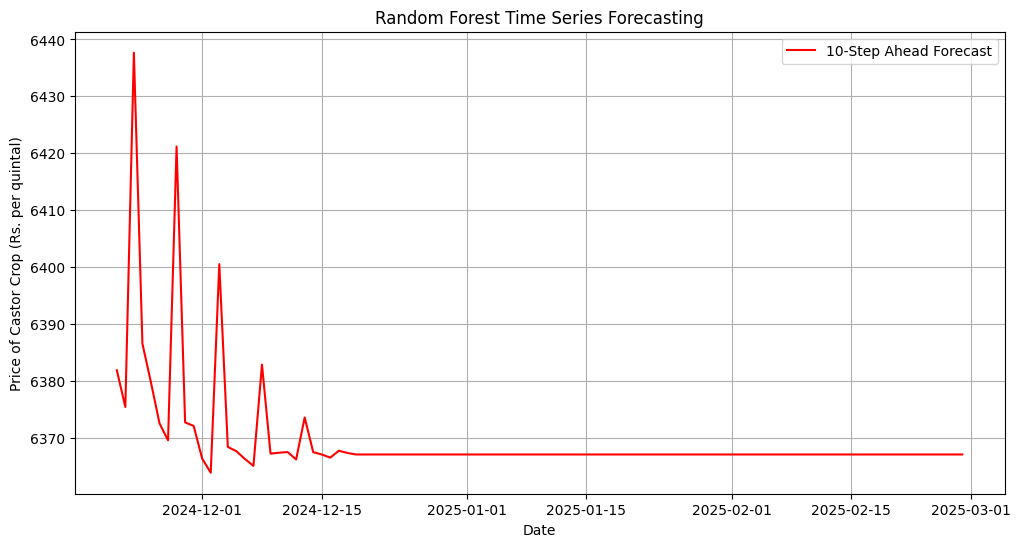

In [39]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['Forecasted_Price'], label='10-Step Ahead Forecast', color='red')
# Labels and title
plt.xlabel('Date')
plt.ylabel('Price of Castor Crop (Rs. per quintal)')
plt.legend()
plt.title('Random Forest Time Series Forecasting')
plt.grid(True)

# Show the plot
plt.show()